making a classive tick-voulume updown convertor wwith 0.25 cluster precesion

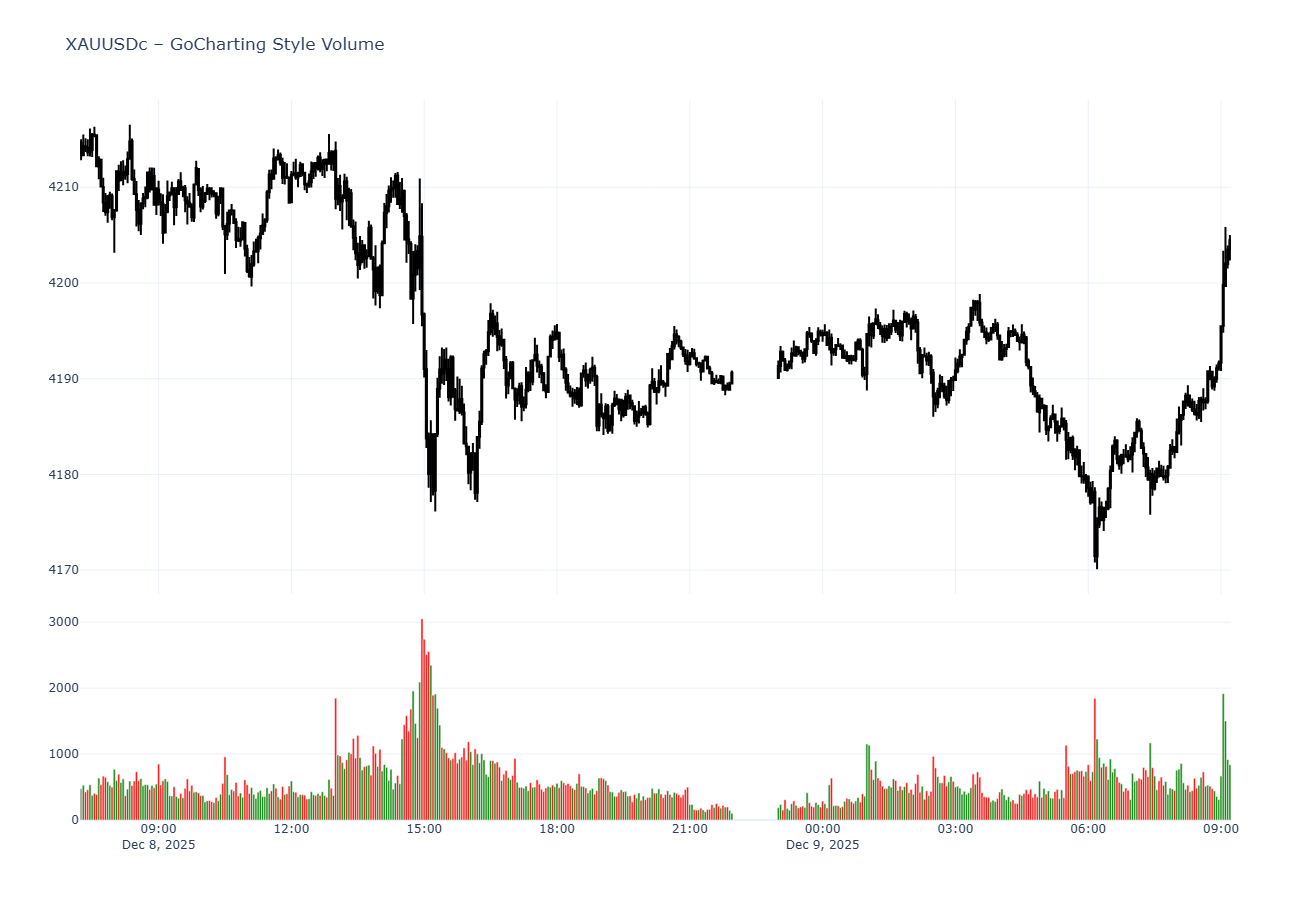

In [6]:
import MetaTrader5 as mt5
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ------------------------------------------------------------
# CONNECT TO MT5
# ------------------------------------------------------------
if not mt5.initialize():
    raise RuntimeError("MT5 Initialize failed. Check if MetaTrader5 terminal is running.")

symbol = "XAUUSDc"
tf = mt5.TIMEFRAME_M3

if not mt5.symbol_select(symbol, True):
    raise RuntimeError(f"Symbol not found: {symbol}")

rates = mt5.copy_rates_from_pos(symbol, tf, 0, 500)
mt5.shutdown()

df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')

# ------------------------------------------------------------
# GOCHARTING-STYLE VOLUME COLORING LOGIC
# ------------------------------------------------------------
# Color logic:
# Green = bullish (close > previous close)
# Red   = bearish (close < previous close)
# Gray  = neutral (close == previous close)

df['prev_close'] = df['close'].shift(1)

def volume_color(row):
    if row['close'] > row['prev_close']:
        return "green"
    elif row['close'] < row['prev_close']:
        return "red"
    else:
        return "gray"

df['vol_color'] = df.apply(volume_color, axis=1)

# ------------------------------------------------------------
# PLOTTING: CANDLE + GOCHARTING VOLUME
# ------------------------------------------------------------
fig = make_subplots(
    rows=2,
    cols=1,
    shared_xaxes=True,
    vertical_spacing=0.02,
    row_heights=[0.7, 0.3]
)

# ---------------------------
# CANDLESTICKS (WHITE THEME)
# ---------------------------
fig.add_trace(
    go.Candlestick(
        x=df['time'],
        open=df['open'],
        high=df['high'],
        low=df['low'],
        close=df['close'],
        name="Price",
        increasing_line_color="black",
        decreasing_line_color="black",
        increasing_fillcolor="white",
        decreasing_fillcolor="white"
    ),
    row=1, col=1
)

# ---------------------------
# GOCHARTING STYLE VOLUME BARS
# ---------------------------
fig.add_trace(
    go.Bar(
        x=df['time'],
        y=df['tick_volume'],
        marker_color=df['vol_color'],
        name="Volume",
        opacity=0.9
    ),
    row=2, col=1
)

# ---------------------------
# CLEAN WHITE LAYOUT
# ---------------------------
fig.update_layout(
    template="plotly_white",
    title="XAUUSDc – GoCharting Style Volume",
    height=900,
    bargap=0.05,             # Narrow spacing like GoCharting
    showlegend=False,
)

fig.update_xaxes(rangeslider_visible=False)

fig.show()


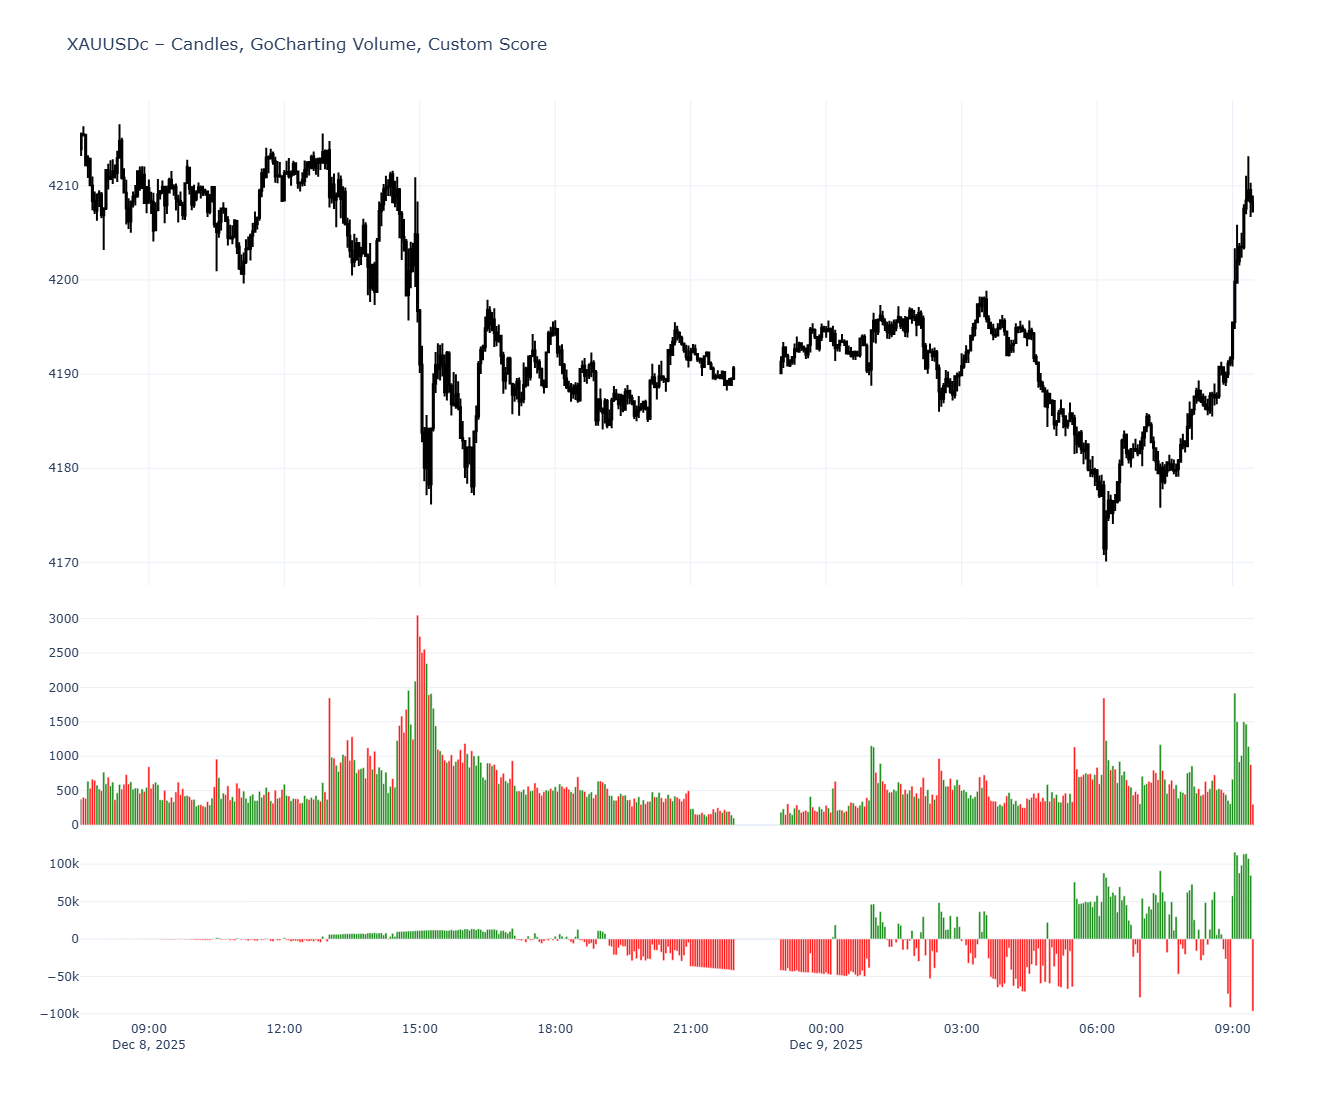

In [10]:
import MetaTrader5 as mt5
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ------------------------------------------------------------
# CONNECT TO MT5
# ------------------------------------------------------------
if not mt5.initialize():
    raise RuntimeError("MT5 Initialize failed. Check MT5 terminal status.")

symbol = "XAUUSDc"
tf = mt5.TIMEFRAME_M3

if not mt5.symbol_select(symbol, True):
    raise RuntimeError(f"Cannot select symbol: {symbol}")

rates = mt5.copy_rates_from_pos(symbol, tf, 0, 500)
mt5.shutdown()

df = pd.DataFrame(rates)
df["time"] = pd.to_datetime(df["time"], unit="s")

# ------------------------------------------------------------
# GOCHARTING-STYLE VOLUME COLOR LOGIC
# ------------------------------------------------------------
df["prev_close"] = df["close"].shift(1)

def vol_color(row):
    if row["close"] > row["prev_close"]:
        return "green"
    elif row["close"] < row["prev_close"]:
        return "red"
    else:
        return "gray"

df["vol_color"] = df.apply(vol_color, axis=1)

# ------------------------------------------------------------
# CUSTOM SCORE ALGORITHM
# Positive/Negative scoring based on tick volume & lookback
# ------------------------------------------------------------

def compute_custom_score(series, index):
    """
    For bar i:
    +1 if vol[i] > vol[i-1]
    +2 if vol[i] > vol[i-2]
    +3 if vol[i] > vol[i-3]
    …
    -1 if vol[i] < vol[i-1]
    -2 if vol[i] < vol[i-2]
    -3 if vol[i] < vol[i-3]
    Unlimited scoring as long as lookbacks apply.
    """
    score = 0
    current_vol = series[index]

    # loop through all possible lookbacks
    for lb in range(1, index + 1):
        comp_vol = series[index - lb]
        if current_vol > comp_vol:
            score += lb
        elif current_vol < comp_vol:
            score -= lb
        # equal → score += 0

    return score

scores = []
for i in range(len(df)):
    scores.append(compute_custom_score(df["tick_volume"], i))

df["custom_score"] = scores

# ------------------------------------------------------------
# FIGURE LAYOUT: 3 PANES
# 1. Candles
# 2. GoCharting Volume
# 3. Custom Score Bar Plot
# ------------------------------------------------------------

fig = make_subplots(
    rows=3,
    cols=1,
    shared_xaxes=True,
    vertical_spacing=0.02,
    row_heights=[0.55, 0.25, 0.20]
)

# ------------------------------------------------------------
# 1. CANDLESTICKS
# ------------------------------------------------------------
fig.add_trace(
    go.Candlestick(
        x=df["time"],
        open=df["open"],
        high=df["high"],
        low=df["low"],
        close=df["close"],
        name="XAUUSDc",
        increasing_line_color="black",
        decreasing_line_color="black",
        increasing_fillcolor="white",
        decreasing_fillcolor="white"
    ),
    row=1, col=1
)

# ------------------------------------------------------------
# 2. GOCHARTING-STYLE VOLUME
# ------------------------------------------------------------
fig.add_trace(
    go.Bar(
        x=df["time"],
        y=df["tick_volume"],
        marker_color=df["vol_color"],
        name="Volume",
        opacity=0.9
    ),
    row=2, col=1
)

# ------------------------------------------------------------
# 3. CUSTOM SCORE BAR PLOT
# ------------------------------------------------------------
fig.add_trace(
    go.Bar(
        x=df["time"],
        y=df["custom_score"],
        marker_color=df["custom_score"].apply(lambda x: "green" if x > 0 else "red" if x < 0 else "gray"),
        name="Custom Score",
        opacity=0.9
    ),
    row=3, col=1
)

# ------------------------------------------------------------
# CHART LAYOUT (WHITE THEME)
# ------------------------------------------------------------
fig.update_layout(
    template="plotly_white",
    title="XAUUSDc – Candles, GoCharting Volume, Custom Score",
    height=1100,
    bargap=0.05,
    showlegend=False
)

fig.update_xaxes(rangeslider_visible=False)

fig.show()


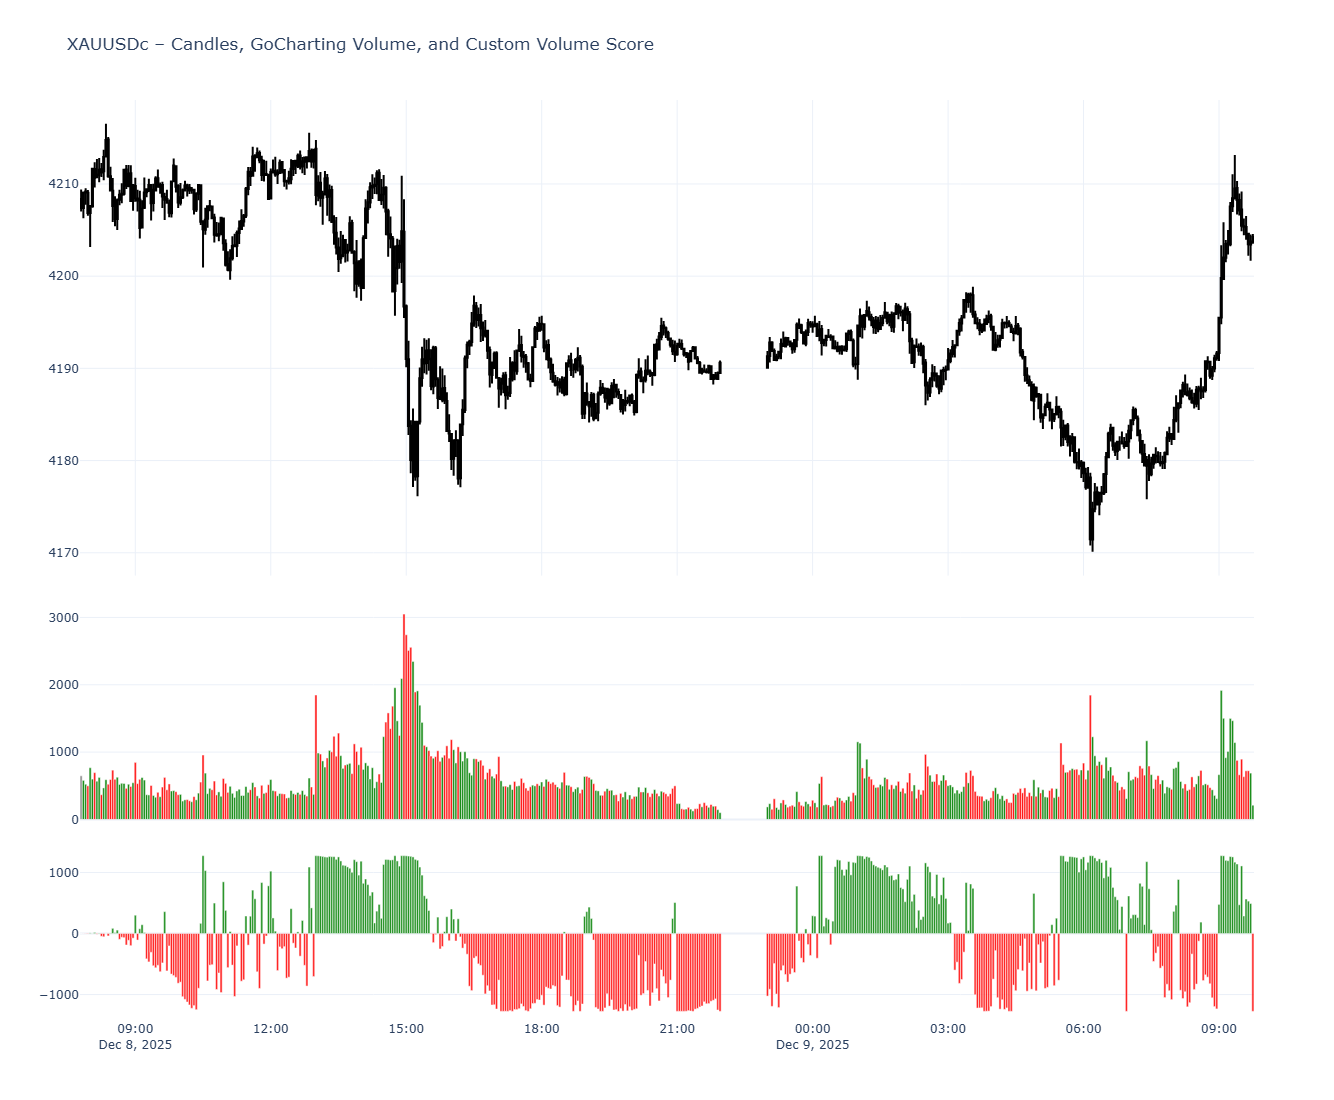

In [19]:
import MetaTrader5 as mt5
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ------------------------------------------------------------
# MT5 CONNECTION
# ------------------------------------------------------------
if not mt5.initialize():
    raise RuntimeError("MT5 failed to initialize.")

symbol = "XAUUSDc"
tf = mt5.TIMEFRAME_M3

if not mt5.symbol_select(symbol, True):
    raise RuntimeError("Symbol selection failed.")

rates = mt5.copy_rates_from_pos(symbol, tf, 0, 500)
mt5.shutdown()

df = pd.DataFrame(rates)
df["time"] = pd.to_datetime(df["time"], unit="s")

# ------------------------------------------------------------
# GOCHARTING STYLE VOLUME COLORING
# ------------------------------------------------------------
df["prev_close"] = df["close"].shift(1)

def volume_color(row):
    if row["close"] > row["prev_close"]:
        return "green"
    elif row["close"] < row["prev_close"]:
        return "red"
    else:
        return "gray"

df["vol_color"] = df.apply(volume_color, axis=1)

# ------------------------------------------------------------
# CUSTOM SCORING ALGORITHM
# ------------------------------------------------------------
def compute_score(series, max_lookback=50):
    """
    Apply scoring rules:
    +n if volume > volume[n]
    -n if volume < volume[n]
    Score accumulates for each bar.
    """
    scores = []

    for i in range(len(series)):
        score = 0
        for lb in range(1, max_lookback + 1):
            if i - lb < 0:
                break

            if series[i] > series[i - lb]:
                score += lb   # positive score
            elif series[i] < series[i - lb]:
                score -= lb   # negative score
            else:
                pass  # no score for equal

        scores.append(score)

    return scores

df["score"] = compute_score(df["tick_volume"], max_lookback=50)

# ------------------------------------------------------------
# PLOTTING (3 PANES)
# ------------------------------------------------------------
fig = make_subplots(
    rows=3,
    cols=1,
    shared_xaxes=True,
    vertical_spacing=0.03,
    row_heights=[0.55, 0.25, 0.20]
)

# ---------------------------
# 1. CANDLESTICKS
# ---------------------------
fig.add_trace(
    go.Candlestick(
        x=df["time"],
        open=df["open"],
        high=df["high"],
        low=df["low"],
        close=df["close"],
        increasing_line_color="black",
        decreasing_line_color="black",
        increasing_fillcolor="white",
        decreasing_fillcolor="white",
        name="Price"
    ),
    row=1, col=1
)

# ---------------------------
# 2. GOCHARTING VOLUME BARS
# ---------------------------
fig.add_trace(
    go.Bar(
        x=df["time"],
        y=df["tick_volume"],
        marker_color=df["vol_color"],
        name="Tick Volume",
        opacity=0.9
    ),
    row=2, col=1
)

# ---------------------------
# 3. CUSTOM SCORE BAR PLOT
# ---------------------------
fig.add_trace(
    go.Bar(
        x=df["time"],
        y=df["score"],
        name="Volume Score",
        marker_color=df["score"].apply(lambda s: "green" if s > 0 else "red" if s < 0 else "gray"),
        opacity=0.85
    ),
    row=3, col=1
)

# ---------------------------
# LAYOUT
# ---------------------------
fig.update_layout(
    template="plotly_white",
    height=1100,
    title="XAUUSDc – Candles, GoCharting Volume, and Custom Volume Score",
    bargap=0.05,
    showlegend=False
)

fig.update_xaxes(rangeslider_visible=False)

fig.show()


C:\Users\User\AppData\Local\Temp\ipykernel_940\1363631068.py:49: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\User\AppData\Local\Temp\ipykernel_940\1363631068.py:61: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



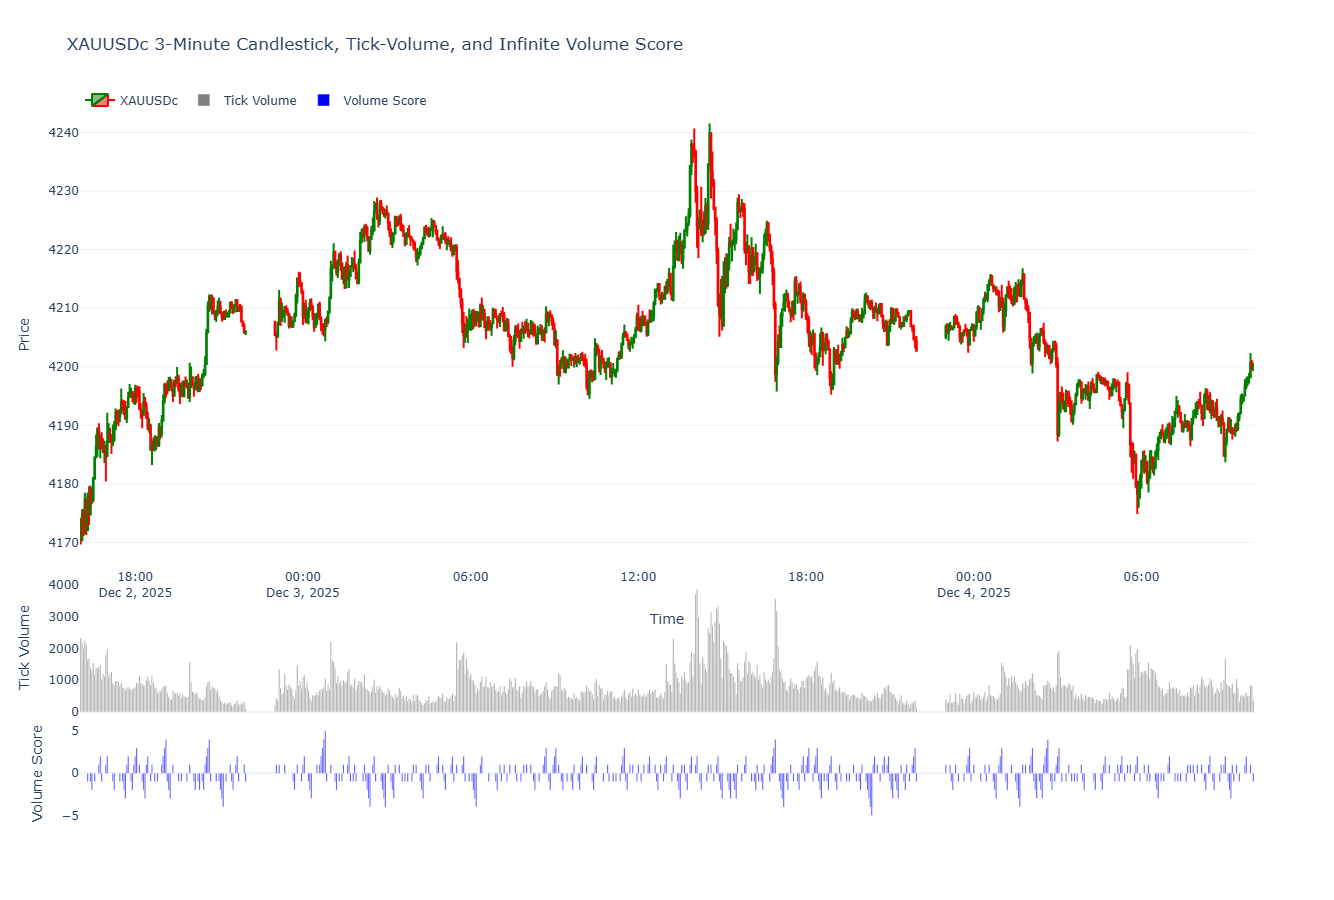

In [22]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime, timedelta

# -------------------------
# 1. Initialize MT5
# -------------------------
if not mt5.initialize():
    print("MT5 initialization failed")
    mt5.shutdown()

# -------------------------
# 2. Fetch 3-minute data
# -------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M3
n_bars = 800
utc_from = datetime.now() - timedelta(days=5)

rates = mt5.copy_rates_from(symbol, timeframe, utc_from, n_bars)
mt5.shutdown()

# -------------------------
# 3. Convert to DataFrame
# -------------------------
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)

# -------------------------
# 4. Remove non-trading periods
# -------------------------
df = df[df.index.dayofweek < 5]

# -------------------------
# 5. Custom infinite volume score indicator
# -------------------------
def infinite_volume_score(volumes, lookback=3):
    scores = np.zeros(len(volumes))
    pos_seq = 0  # positive sequence counter
    neg_seq = 0  # negative sequence counter

    for i in range(lookback, len(volumes)):
        # Positive sequence check
        is_positive = True
        for lb in range(1, lookback + 1):
            if volumes[i] <= volumes[i - lb]:
                is_positive = False
                break
        if is_positive:
            pos_seq += 1
            scores[i] = pos_seq
        else:
            pos_seq = 0

        # Negative sequence check
        is_negative = True
        for lb in range(1, lookback + 1):
            if volumes[i] >= volumes[i - lb]:
                is_negative = False
                break
        if is_negative:
            neg_seq -= 1
            scores[i] = neg_seq
        else:
            if not is_positive:  # reset only if sequence broken
                scores[i] = 0
            neg_seq = 0

    return scores

df['vol_score'] = infinite_volume_score(df['tick_volume'], lookback=3)

# -------------------------
# 6. Plot 3-pane chart
# -------------------------
fig = go.Figure()

# Candlestick chart (top pane)
fig.add_trace(go.Candlestick(
    x=df.index,
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    name='XAUUSDc',
    increasing_line_color='green',
    decreasing_line_color='red'
))

# Tick-volume bars (middle pane)
fig.add_trace(go.Bar(
    x=df.index,
    y=df['tick_volume'],
    name='Tick Volume',
    marker_color='gray',
    yaxis='y2'
))

# Infinite volume score bars (bottom pane)
fig.add_trace(go.Bar(
    x=df.index,
    y=df['vol_score'],
    name='Volume Score',
    marker_color='blue',
    yaxis='y3'
))

# Layout with 3 panes
fig.update_layout(
    template='plotly_white',
    title='XAUUSDc 3-Minute Candlestick, Tick-Volume, and Infinite Volume Score',
    xaxis=dict(title='Time', rangeslider=dict(visible=False)),
    yaxis=dict(title='Price', domain=[0.35, 1]),
    yaxis2=dict(title='Tick Volume', domain=[0.15, 0.33], showgrid=False),
    yaxis3=dict(title='Volume Score', domain=[0, 0.13], showgrid=False),
    legend=dict(orientation='h', y=1.02, x=0),
    height=900
)

fig.show()


if the volume score is -3 or -4 or -5 or so on, locate the candlestick close and mark it.
if the volume score is 3 or 4 or 5 or so on, locate the candlestick close and mark it.

mark candlestick closes whenever the infinite volume score reaches ±3 or higher in magnitude.

C:\Users\User\AppData\Local\Temp\ipykernel_940\3310478248.py:49: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\User\AppData\Local\Temp\ipykernel_940\3310478248.py:61: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



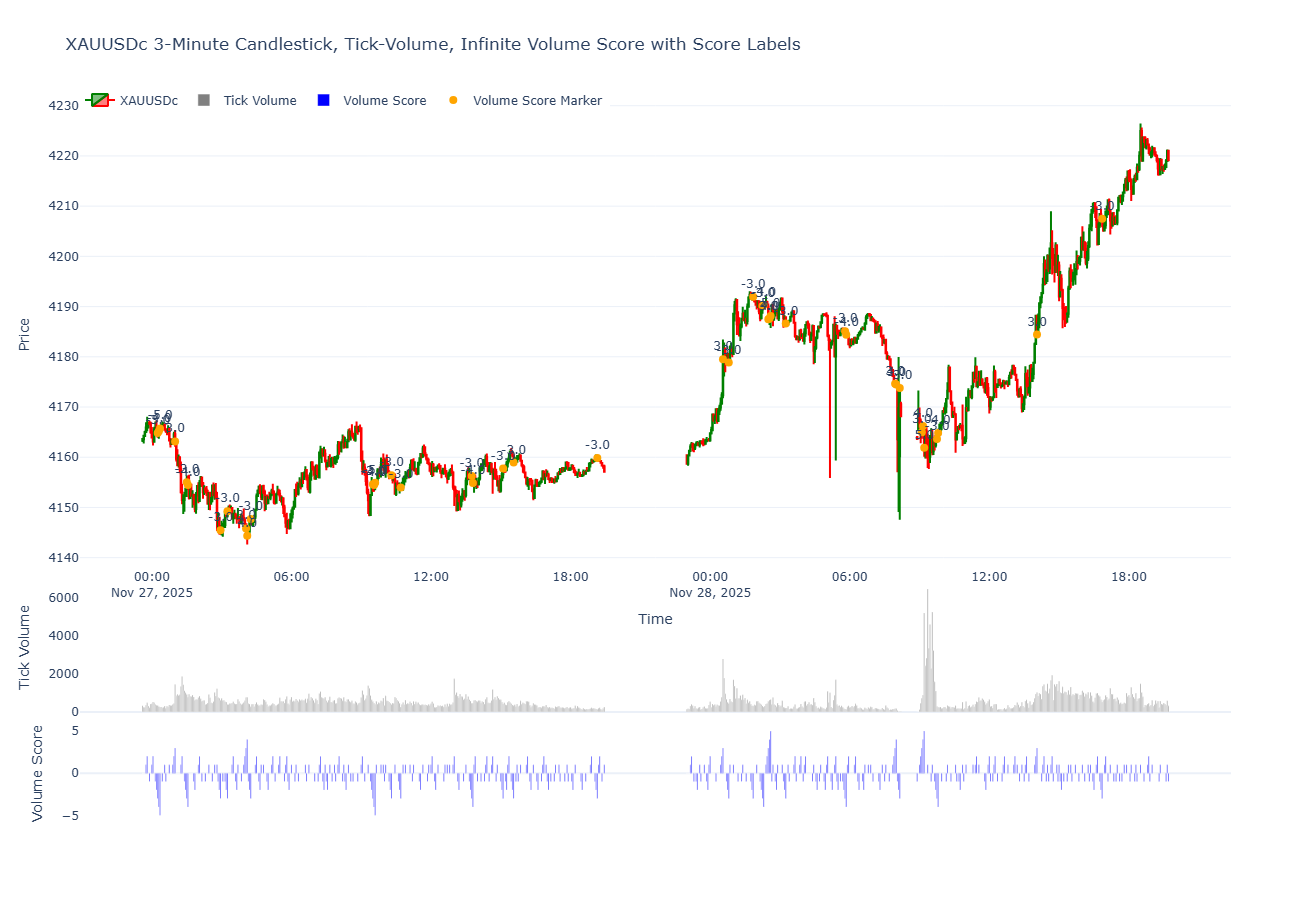

In [25]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime, timedelta

# -------------------------
# 1. Initialize MT5
# -------------------------
if not mt5.initialize():
    print("MT5 initialization failed")
    mt5.shutdown()

# -------------------------
# 2. Fetch 3-minute data
# -------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M3
n_bars = 800
utc_from = datetime.now() - timedelta(days=10)

rates = mt5.copy_rates_from(symbol, timeframe, utc_from, n_bars)
mt5.shutdown()

# -------------------------
# 3. Convert to DataFrame
# -------------------------
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)

# -------------------------
# 4. Remove non-trading periods
# -------------------------
df = df[df.index.dayofweek < 5]

# -------------------------
# 5. Infinite volume score logic
# -------------------------
def infinite_volume_score(volumes, lookback=3):
    scores = np.zeros(len(volumes))
    pos_seq = 0
    neg_seq = 0

    for i in range(lookback, len(volumes)):
        # Positive sequence
        is_positive = True
        for lb in range(1, lookback + 1):
            if volumes[i] <= volumes[i - lb]:
                is_positive = False
                break
        if is_positive:
            pos_seq += 1
            scores[i] = pos_seq
        else:
            pos_seq = 0

        # Negative sequence
        is_negative = True
        for lb in range(1, lookback + 1):
            if volumes[i] >= volumes[i - lb]:
                is_negative = False
                break
        if is_negative:
            neg_seq -= 1
            scores[i] = neg_seq
        else:
            if not is_positive:
                scores[i] = 0
            neg_seq = 0

    return scores

df['vol_score'] = infinite_volume_score(df['tick_volume'], lookback=3)

# -------------------------
# 6. Find markers for score >=3 or <=-3
# -------------------------
mask = df['vol_score'].abs() >= 3
df['marker'] = np.where(mask, df['close'], np.nan)
df['marker_label'] = np.where(mask, df['vol_score'], "")

# -------------------------
# 7. Plot 3-pane chart with score labels
# -------------------------
fig = go.Figure()

# Candlestick chart (top pane)
fig.add_trace(go.Candlestick(
    x=df.index,
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    name='XAUUSDc',
    increasing_line_color='green',
    decreasing_line_color='red'
))

# Tick-volume bars (middle pane)
fig.add_trace(go.Bar(
    x=df.index,
    y=df['tick_volume'],
    name='Tick Volume',
    marker_color='gray',
    yaxis='y2'
))

# Volume score bars (bottom pane)
fig.add_trace(go.Bar(
    x=df.index,
    y=df['vol_score'],
    name='Volume Score',
    marker_color='blue',
    yaxis='y3'
))

# Markers for high/low volume score closes with labels
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['marker'],
    mode='markers+text',
    text=df['marker_label'],
    textposition='top center',
    marker=dict(color='orange', size=8, symbol='circle'),
    name='Volume Score Marker',
    yaxis='y'
))

# Layout
fig.update_layout(
    template='plotly_white',
    title='XAUUSDc 3-Minute Candlestick, Tick-Volume, Infinite Volume Score with Score Labels',
    xaxis=dict(title='Time', rangeslider=dict(visible=False)),
    yaxis=dict(title='Price', domain=[0.35, 1]),
    yaxis2=dict(title='Tick Volume', domain=[0.15, 0.33], showgrid=False),
    yaxis3=dict(title='Volume Score', domain=[0, 0.13], showgrid=False),
    legend=dict(orientation='h', y=1.02, x=0),
    height=900
)

fig.show()


This algorithm only uses tick-volume bars (one whole bar, entire value) as a comparative-variable. The “score” is assigned to each corresponding bar, at the current bar. The score varies how many times does this current bar’s entire value, higher than the number of lookback bars. The greater the number of lookback bars, the greater the score. The scoring only ends with a horizontal intersection point from the entire value of the current bar, compared to the look back to the left. For example: The current bar is higher than all in 12 lookback, then the corresponding score will be “12”. The scoring is infinite no matter how much data set is used.

C:\Users\User\AppData\Local\Temp\ipykernel_940\3809146716.py:47: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



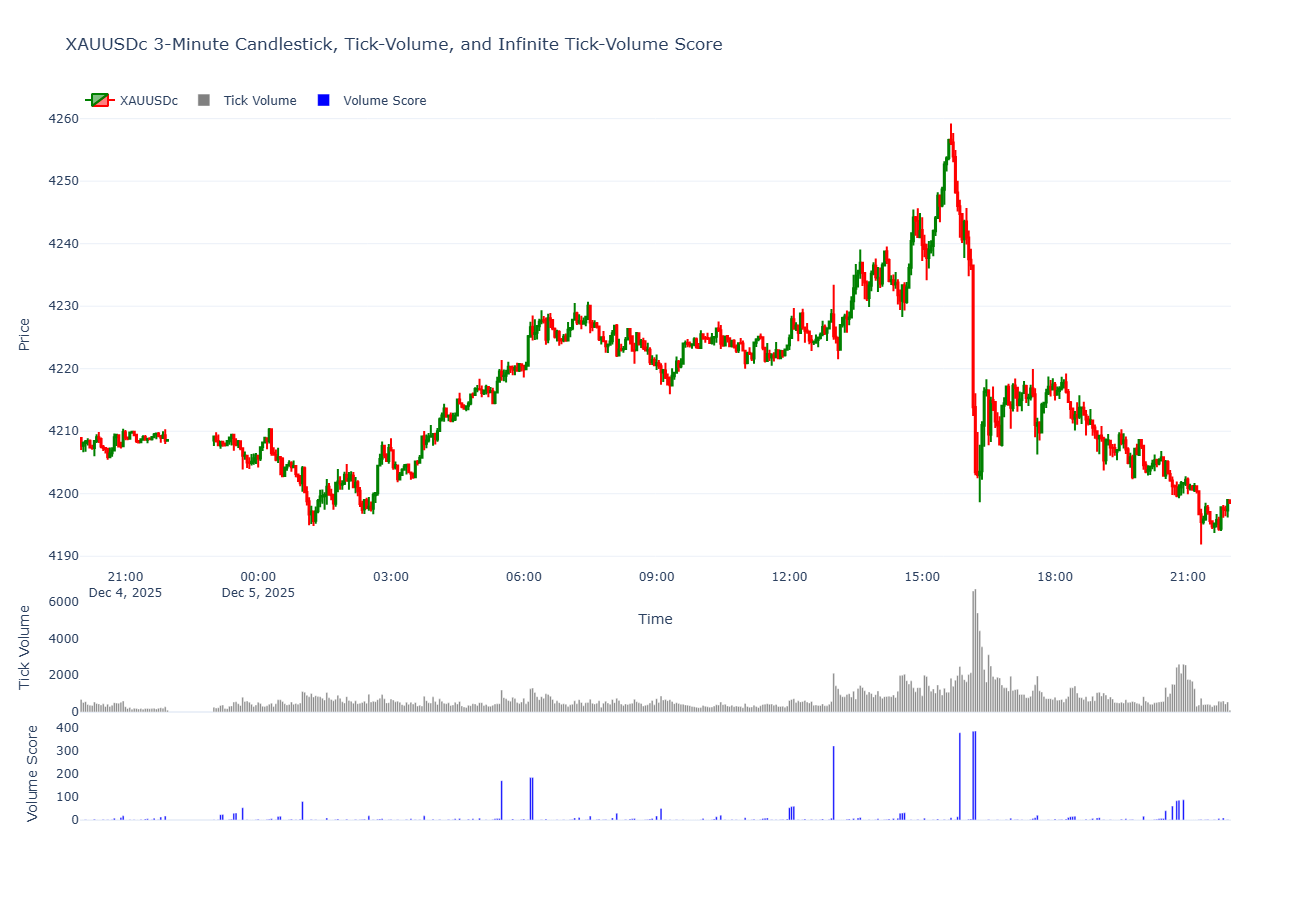

In [33]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime, timedelta

# -------------------------
# 1. Initialize MT5
# -------------------------
if not mt5.initialize():
    print("MT5 initialization failed")
    mt5.shutdown()

# -------------------------
# 2. Fetch 3-minute data
# -------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M3
n_bars = 500
utc_from = datetime.now() - timedelta(days=2)

rates = mt5.copy_rates_from(symbol, timeframe, utc_from, n_bars)
mt5.shutdown()

# -------------------------
# 3. Convert to DataFrame
# -------------------------
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)

# -------------------------
# 4. Remove non-trading periods (weekends)
# -------------------------
df = df[df.index.dayofweek < 5]

# -------------------------
# 5. Infinite tick-volume score algorithm (horizontal intersection logic)
# -------------------------
def tick_volume_infinite_score(volumes):
    scores = np.zeros(len(volumes))
    
    for i in range(1, len(volumes)):
        count = 0
        # Compare current bar to all previous bars to the left until intersection
        for j in range(i-1, -1, -1):
            if volumes[i] > volumes[j]:
                count += 1
            else:
                break  # horizontal intersection, stop counting
        scores[i] = count
    return scores

df['vol_score'] = tick_volume_infinite_score(df['tick_volume'])

# -------------------------
# 6. Plot 3-pane chart (no markers)
# -------------------------
fig = go.Figure()

# Candlestick chart (top pane)
fig.add_trace(go.Candlestick(
    x=df.index,
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    name='XAUUSDc',
    increasing_line_color='green',
    decreasing_line_color='red'
))

# Tick-volume bars (middle pane)
fig.add_trace(go.Bar(
    x=df.index,
    y=df['tick_volume'],
    name='Tick Volume',
    marker_color='gray',
    yaxis='y2'
))

# Volume score bars (bottom pane)
fig.add_trace(go.Bar(
    x=df.index,
    y=df['vol_score'],
    name='Volume Score',
    marker_color='blue',
    yaxis='y3'
))

# Layout
fig.update_layout(
    template='plotly_white',
    title='XAUUSDc 3-Minute Candlestick, Tick-Volume, and Infinite Tick-Volume Score',
    xaxis=dict(title='Time', rangeslider=dict(visible=False)),
    yaxis=dict(title='Price', domain=[0.35, 1]),
    yaxis2=dict(title='Tick Volume', domain=[0.15, 0.33], showgrid=False),
    yaxis3=dict(title='Volume Score', domain=[0, 0.13], showgrid=False),
    legend=dict(orientation='h', y=1.02, x=0),
    height=900
)

fig.show()


If the volume score (position 0) is higher than the neighboring candles position -1 and +1, then locate the corresponding candle stick which is at position 0. Draw a box and extend it to the right value of 10 bars.

C:\Users\User\AppData\Local\Temp\ipykernel_940\3455226501.py:45: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



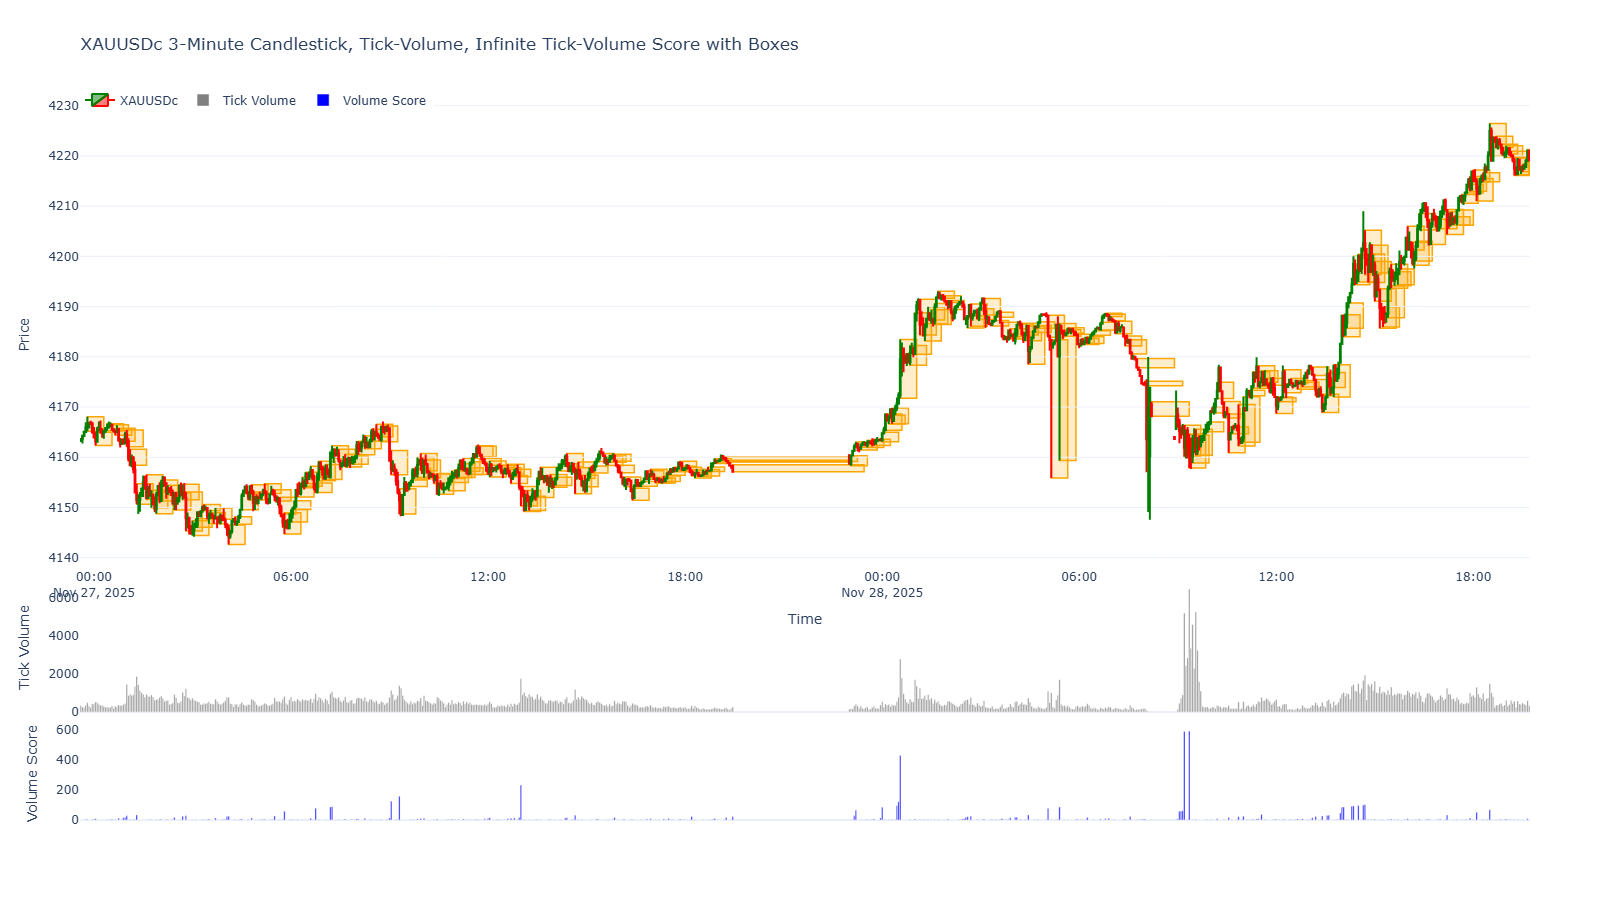

In [34]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime, timedelta

# -------------------------
# 1. Initialize MT5
# -------------------------
if not mt5.initialize():
    print("MT5 initialization failed")
    mt5.shutdown()

# -------------------------
# 2. Fetch 3-minute data
# -------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M3
n_bars = 800
utc_from = datetime.now() - timedelta(days=10)

rates = mt5.copy_rates_from(symbol, timeframe, utc_from, n_bars)
mt5.shutdown()

# -------------------------
# 3. Convert to DataFrame
# -------------------------
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)

# -------------------------
# 4. Remove non-trading periods (weekends)
# -------------------------
df = df[df.index.dayofweek < 5]

# -------------------------
# 5. Infinite tick-volume score algorithm
# -------------------------
def tick_volume_infinite_score(volumes):
    scores = np.zeros(len(volumes))
    for i in range(1, len(volumes)):
        count = 0
        for j in range(i-1, -1, -1):
            if volumes[i] > volumes[j]:
                count += 1
            else:
                break
        scores[i] = count
    return scores

df['vol_score'] = tick_volume_infinite_score(df['tick_volume'])

# -------------------------
# 6. Box logic for local maxima
# -------------------------
boxes = []

for i in range(1, len(df)-1):
    if df['vol_score'].iloc[i] > df['vol_score'].iloc[i-1] and df['vol_score'].iloc[i] > df['vol_score'].iloc[i+1]:
        # Current candlestick
        x0 = df.index[i]
        x1 = df.index[min(i+10, len(df)-1)]  # extend to the right 10 bars
        y0 = df['low'].iloc[i]
        y1 = df['high'].iloc[i]
        boxes.append(dict(type="rect",
                          xref="x",
                          yref="y",
                          x0=x0,
                          x1=x1,
                          y0=y0,
                          y1=y1,
                          line=dict(color="orange", width=1.5),
                          fillcolor="rgba(255,165,0,0.2)",
                          layer="below"))

# -------------------------
# 7. Plot 3-pane chart
# -------------------------
fig = go.Figure()

# Candlestick chart (top pane)
fig.add_trace(go.Candlestick(
    x=df.index,
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    name='XAUUSDc',
    increasing_line_color='green',
    decreasing_line_color='red'
))

# Tick-volume bars (middle pane)
fig.add_trace(go.Bar(
    x=df.index,
    y=df['tick_volume'],
    name='Tick Volume',
    marker_color='gray',
    yaxis='y2'
))

# Volume score bars (bottom pane)
fig.add_trace(go.Bar(
    x=df.index,
    y=df['vol_score'],
    name='Volume Score',
    marker_color='blue',
    yaxis='y3'
))

# Add boxes for local maxima
fig.update_layout(shapes=boxes)

# Layout
fig.update_layout(
    template='plotly_white',
    title='XAUUSDc 3-Minute Candlestick, Tick-Volume, Infinite Tick-Volume Score with Boxes',
    xaxis=dict(title='Time', rangeslider=dict(visible=False)),
    yaxis=dict(title='Price', domain=[0.35, 1]),
    yaxis2=dict(title='Tick Volume', domain=[0.15, 0.33], showgrid=False),
    yaxis3=dict(title='Volume Score', domain=[0, 0.13], showgrid=False),
    legend=dict(orientation='h', y=1.02, x=0),
    height=900
)

fig.show()


In [ ]:
If the volume score (position 0) is 10 times (10x) higher than the previous bar (position -1) then draw a box at the corresponding candlestick (extend +5 bars to the right